# thinking process

1. simulated data come from another notebook I wrote, which involved domain knowledge referred from a coating paper
2. goal of this notebook is to explore bayesian optimization.

3. X array include machine parameters, ink properties values

4. y is reward, I want min (-reward), idea from slot-die env reward design

5. I want to design the loss function with quantile weight, inspired by quantle loss regression idea.

6. for slot die coating, two edge cases are: leaking, right: breaking-up

7. leakings are zero-tolerance defects. goal is to encourage more prediction points on right side

    L(x_u,x_f) = (x_f - x_u)*tao if x_u > half point;

           = (x_u - 0)*(1-tao) if x_u < half point
    
    interpretation : if tao = 0.1, then L will be larger for points located on left side, which potentially reach to leaking condition Goal to minimize L(f)

8. make calculation for idea 7

9. sampling for bayesian by changing ink property value? prove it later

# Bayesian structure designs
1. define the objective function that max rewards
    def objective(X_array):
        calculate process
        get x_estimate 
        return x_f - x_estimate
        
2. define domain space
    domain spaces include all input variables from ink property and machine setting parameters 
    it is a array (nRows,nFeatures)
 
3. define optimization algorithm
   
4. get result and visual -- future steps: hyperparameters tunning 

In [2]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor

In [3]:
# read data first 
# make X array and object function value 
nn_df = pd.read_csv("Non_Newtonian_Simulation_V1.csv").iloc[:,1:]
nn_df

,modified_CA,Non_Newtonian_Stable,Xu_location(um),theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio,thickness(um),ambient_pressure(Pa)
0,0.059062,0,-0.002970,120,60,0.05,16,200.0,1.5,133.333333,1.429375
1,0.059062,-1,0.000552,120,60,0.05,16,200.0,2.0,100.000000,1.429375
2,0.059062,-1,0.003242,120,60,0.05,16,200.0,2.5,80.000000,1.429375
3,0.059062,-1,0.004088,120,60,0.05,16,200.0,3.0,66.666667,1.429375
4,0.059062,-1,0.004601,120,60,0.05,16,200.0,3.5,57.142857,1.429375
...,...,...,...,...,...,...,...,...,...,...,...
94075,0.194801,-1,0.003857,160,120,0.65,60,500.0,3.0,166.666667,241.564375
94076,0.194801,-1,0.004375,160,120,0.65,60,500.0,3.5,142.857143,241.564375
94077,0.194801,-1,0.004735,160,120,0.65,60,500.0,4.0,125.000000,241.564375
94078,0.194801,-1,0.005003,160,120,0.65,60,500.0,4.5,111.111111,241.564375


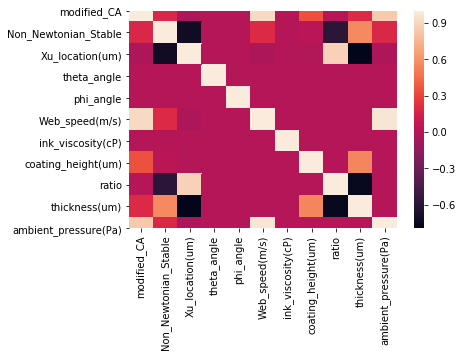

In [9]:
# some columns in nn_df have correlations, so I only select columns with no correlation based on domain knowledge
# correlation can also be detected by heat map
# five parameters : theta, phi, U, mu, g, r 

import seaborn as sns
corr = nn_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [13]:
corr[(corr.abs()>0.7) & (corr.abs() < 1.0)]

,modified_CA,Non_Newtonian_Stable,Xu_location(um),theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio,thickness(um),ambient_pressure(Pa)
modified_CA,NaN,NaN,NaN,NaN,NaN,0.912389,NaN,NaN,NaN,NaN,0.839359
Non_Newtonian_Stable,NaN,NaN,-0.714527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Xu_location(um),NaN,-0.714527,NaN,NaN,NaN,NaN,NaN,NaN,0.874848,-0.792715,NaN
theta_angle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
phi_angle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Web_speed(m/s),0.912389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.970725
ink_viscosity(cP),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coating_height(um),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ratio,NaN,NaN,0.874848,NaN,NaN,NaN,NaN,NaN,NaN,-0.756802,NaN
thickness(um),NaN,NaN,-0.792715,NaN,NaN,NaN,NaN,NaN,-0.756802,NaN,NaN


In [4]:
input_list = ["theta_angle","phi_angle","Web_speed(m/s)","ink_viscosity(cP)","coating_height(um)","ratio"]
X_array_nn = nn_df[[*input_list]]
X_array_nn

,theta_angle,phi_angle,Web_speed(m/s),ink_viscosity(cP),coating_height(um),ratio
0,120,60,0.05,16,200.0,1.5
1,120,60,0.05,16,200.0,2.0
2,120,60,0.05,16,200.0,2.5
3,120,60,0.05,16,200.0,3.0
4,120,60,0.05,16,200.0,3.5
...,...,...,...,...,...,...
94075,160,120,0.65,60,500.0,3.0
94076,160,120,0.65,60,500.0,3.5
94077,160,120,0.65,60,500.0,4.0
94078,160,120,0.65,60,500.0,4.5


# three components in Bayesian 
1. surrogate: posterior 
2. acquisition: Sampling involves careful use of the posterior i: usually EI

posterior = likelihood * prior
(conditional prob) = (reverse of conditional prob) * marginal prob

The posterior represents everything we know about the objective function. It is an approximation of the objective function and can be used to estimate the cost of different candidate samples that we may want to evaluate.

so, the posterior probability is a surrogate objective function.

surrogate = P(D|f) * object function

P(f|D) = P(D|f) * P(f)

1. Select a Sample by Optimizing the Acquisition Function.
2. Evaluate the Sample With the Objective Function.
3. Update the Data and, in turn, the Surrogate Function.
4. Go To 1.

In [ ]:
# surrogate: use GaussianProcessRegressor
# acquisition: EI (do more research later)
# new samples: use ideas from RL env to generate new samples 

In [1]:
def objective(x_u,x_f,quantile):
    """
    objective function to minimize
    
    loss function with quantile weight, inspired by quantle loss regression idea.

    for slot die coating, two edge cases are: leaking, right: breaking-up

    leakings are zero-tolerance defects. goal is to encourage more prediction points on right side

    L(x_u,x_f) = (x_f - x_u)*tao if x_u -half point > 0;

               = (x_u - 0)*(1-tao) if x_u - half point < 0 
    
    interpretation : if tao = 0.1, then L will be larger for points located on left side, which potentially reach to leaking condition Goal to minimize L(f)
   
    """
    y = []
    if x_u > x_f/2:
        y.append((x_f - x_u)*quantile)
    elif x_u < x_f/2:
        y.append(x_u*(1-quantile))
    return y
        

In [ ]:
class Bayesian_opt():
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        # initial values
        self.x_init = x_init
        self.y_init = y_init
        self.n_iter = n_iter
        self.scale = scale  # figure out why 
        self.batch_size = batch_size  # figure out why 
        self.best_samples = pd.DataFrame(columns = (input_list + ["y","ei"]))
        self.gauss_pr = GaussianProcessRegressor()
        self.distances_ = []
    # surrogate function using EI method, as a starting point  
    def _get_expected_improvement(self, x_new): 
        # do more research on different methods and figure out why choose EI
        # Using estimate from Gaussian surrogate instead of actual function for a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new <= 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for entire prior distribution to avoid cost
        # add a very small to avoid divide by zero sigma 
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)
        z = (mean_y_new - max_mean_y) / (sigma_y_new+1e-9)
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    